## Training the EfficientFormerV2S Model for Lens Finding

* You will need to install tensorflow_addons and keras-cv the first time you run this nb, as it is not in the tensorflow-2.9.0 kernel

In [1]:
# !pip install tensorflow_addons
# !pip install keras-cv-attention-models==1.4.2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow as tf
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization as BatchNorm
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, Model, Input
import keras_cv_attention_models as kam

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import tensorflow_addons as tfa
from datetime import date
import time

In [3]:
!nvidia-smi 

# Run the following in a terminal to monitor VRAM during training
# watch -n 0.5 nvidia-smi

Fri Jul 11 12:26:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:C3:00.0 Off |                    0 |
| N/A   48C    P0             94W /  250W |   32433MiB /  40960MiB |     62%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
deluxe = '/global/cfs/projectdirs/cosmo/work/users/xhuang/dr10_1/Clean-Samples/TS40_deluxe_clean'
ethan = '/global/cfs/projectdirs/deepsrch/jwst_sims/pristine_bright/'
bryce = 'pscratch/sd/a/amurr1/Datasets/roman_data_v1.h5'

 * clean deluxe is our highest quality sample, in the Clean-Samples dir you will find TS40 Baseline, which has more samples, but some positive and negative candidates may not be as clear, or have additional noise

In [5]:
path = ethan

x0 = np.load(path+"images.npy")
x0NL = np.load(path+"no_lens.npy")
y0 = np.load(path+"lensed.npy")
cap = np.percentile(x0, 99)

#Image pre-processing
for i in range(len(x0)):
    cap = np.percentile(x0[i],99)
    x0[i][x0[i]>cap]=cap
    x0[i] = (x0[i]-np.mean(x0[i])) / np.std(x0[i])
# for i in range(len(x0)):
#     x0[i] = x0[i] + add_poisson(x0[i], uniform.rvs(loc=150,scale=550))

#train-val split
np.random.seed(15)
indices = np.arange(len(x0))
np.random.shuffle(indices)
start = len(x0)//5 * 0 #0
end = len(x0)//5 * 1 #1
val_inds = indices[start:end]
train_inds = np.concatenate([indices[:start],indices[end:]])

xtrain = x0[train_inds]
xval = x0[val_inds]
ytrain = y0[train_inds]
yval = y0[val_inds]

xtrain = np.reshape(xtrain,(len(xtrain),125,125,1))
xval =  np.reshape(xval, (len(xval),125,125,1))
ytrain = np.reshape(ytrain, (len(ytrain),1))
yval =  np.reshape(yval, (len(yval),1))

xtrain = np.clip(xtrain, -1, 1)  
xval = np.clip(xval, -1, 1)

if xtrain.ndim == 3:
    xtrain = np.expand_dims(xtrain, axis=-1)
if xval.ndim == 3:
    xval = np.expand_dims(xval, axis=-1)

In [31]:
path = deluxe

xtrain = np.load(f"{path}/train_x.npy")
ytrain = np.load(f"{path}/train_y.npy").reshape(-1, 1)

xval = np.load(f"{path}/val_x.npy")
yval = np.load(f"{path}/val_y.npy").reshape(-1, 1)

xtrain = np.clip(xtrain, -1, 1)  
xval = np.clip(xval, -1, 1)

if xtrain.ndim == 3:
    xtrain = np.expand_dims(xtrain, axis=-1)
if xval.ndim == 3:
    xval = np.expand_dims(xval, axis=-1)

print("xtrain type:", type(xtrain))
print("xtrain shape:", getattr(xtrain, 'shape', 'No shape'))
print("xtrain dtype:", getattr(xtrain, 'dtype', 'No dtype'))

print("ytrain type:", type(ytrain))
print("ytrain shape:", getattr(ytrain, 'shape', 'No shape'))
print("ytrain dtype:", getattr(ytrain, 'dtype', 'No dtype'))

# Check a single sample
try:
    print("Sample xtrain[0] shape:", xtrain[0].shape)
    print("Sample ytrain[0]:", ytrain[0])
except Exception as e:
    print("Error accessing sample:", e)

xtrain type: <class 'numpy.ndarray'>
xtrain shape: (94887, 101, 101, 3)
xtrain dtype: float32
ytrain type: <class 'numpy.ndarray'>
ytrain shape: (94887, 1)
ytrain dtype: float64
Sample xtrain[0] shape: (101, 101, 3)
Sample ytrain[0]: [0.]


In [6]:
def ensure_rgb(x):
    if x.shape.rank == 4 and x.shape[-1] == 1:
        x = tf.image.grayscale_to_rgb(x)
    return x
def preprocess(x, y):
    x = tf.image.resize(x, [112, 112])
    x = ensure_rgb(x)
    x = tf.image.random_flip_left_right(tf.image.random_flip_up_down(x))
    rg = tf.random.uniform(shape=[],minval=0, maxval=2 * np.pi, dtype=tf.float32)
    x = tfa.image.rotate(x, angles=rg, fill_mode = 'reflect')
    return x, y
def preprocess_val(x, y):
    x = tf.image.resize(x, [112, 112])
    x = ensure_rgb(x)
    return x, y
# image augmentation to help prevent overfitting in training. 

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF

batch_size = 512
train = (tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
        .map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .shuffle(len(ytrain), reshuffle_each_iteration=True, seed=42) 
        .repeat()
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)).with_options(options)

validate = (tf.data.Dataset.from_tensor_slices((xval, yval))
        .map(preprocess_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .shuffle(len(yval))
        .repeat()
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)).with_options(options)

2025-07-11 12:26:52.714814: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:236] Using CUDA malloc Async allocator for GPU: 0
2025-07-11 12:26:52.716443: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5938 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [7]:
### To resume training, set epoch to last save epoch and set LR to last known LR.
START_EPOCH = 0
lr_stopped_at = 0.0

run_name = "F1"
today = date.today()
d1 = today.strftime("%d_%m_%Y") 
# this WILL override multiple runs on same day because of line 17, 
# rename run name to distinguish between runs on the same day

parent_dir = "_Time_Trials"
save_dir = parent_dir + "/" + d1 + run_name

if START_EPOCH == 0:
    !mkdir {parent_dir}
    !rm -rf {save_dir}
    !mkdir {save_dir}
    print("CREATED DIRECTORY")

mkdir: cannot create directory ‘_Time_Trials’: File exists
CREATED DIRECTORY


In [7]:
metrics = tf.keras.metrics
#strategy = tf.distribute.MirroredStrategy(cross_device_ops = tf.distribute.ReductionToOneDevice())

In [8]:
def create_vit(lr=5e-4):
    input_shape = (112,112,3)
    base_model = kam.efficientformer.EfficientFormerV2S0(input_shape=input_shape, pretrained='imagenet')
    base_model.trainable = True
    
    x = base_model.layers[-2].output
    x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid', dtype='float32')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = [
            metrics.AUC(num_thresholds=1000), 
            metrics.Precision(0.9), 
            metrics.Recall(0.9),
        ],
    )
    return model

In [10]:
checkpoint = ModelCheckpoint(
    f"{save_dir}/chkpt.h5", 
    monitor = f'val_auc', 
    save_best_only = True, 
    mode = 'max', 
    verbose = 1, 
    save_weights_only = True,
)

csv_logger = CSVLogger(
    f"{save_dir}/training_history.csv", 
    separator = ',', 
    append = True,
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

callbacks = [
    checkpoint, 
    csv_logger,
    reduce_lr,
]

In [ ]:
with strategy.scope():
    model = create_eff_vit()

print("Number of devices: {}".format(strategy.num_replicas_in_sync))
start = time.time()
print(f'Start: {start}')

model.fit(
    train, 
    validation_data = validate, 
    epochs = 160, 
    steps_per_epoch = (len(ytrain) // batch_size), 
    callbacks = callbacks, 
    verbose = 1, 
    batch_size = batch_size, 
    validation_steps = (len(yval) // batch_size),
)

end = time.time()
print(f'Total time running: {end-start}')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-07-07 13:47:49.049538: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
2025-07-07 13:47:49.053790: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
2025-07-07 13:47:49.065953: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
2025-07-07 13:47:49.077134: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
2025-07-07 13:47:53.417506: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2fb7090380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-07 13:47:53.417522: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-07-07 13:47:53.417527: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-07-07 13:47:53.417532: I extern

185/185 [==============================] - ETA: 0s - loss: 0.0410 - auc: 0.9304 - precision: 0.2500 - recall: 0.0083             
Epoch 1: val_auc improved from -inf to 0.77968, saving model to _Time_Trials/07_07_2025F1/chkpt.h5
185/185 [==============================] - 86s 128ms/step - loss: 0.0410 - auc: 0.9304 - precision: 0.2500 - recall: 0.0083 - val_loss: 0.0637 - val_auc: 0.7797 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 5.0000e-04
Epoch 2/160
185/185 [==============================] - ETA: 0s - loss: 0.0232 - auc: 0.9782 - precision: 0.9524 - recall: 0.0415         

In [14]:
model.save_weights(f'{save_dir}/endrun.h5')

In [10]:
#save_dir = "/pscratch/sd/a/amurr1/Roman-lens-search/alexisMurray/TransformerExploration/EffFormer/EffFormerV2S0_tf/_Time_Trials/07_07_2025F1"
save_dir = "/pscratch/sd/a/amurr1/Roman-lens-search/alexisMurray/TransformerExploration/EffFormer/EffFormerV2S0_tf/_Time_Trials/11_07_2025F1"
model = create_vit()

>>>> Load pretrained from: /global/homes/a/amurr1/.keras/models/efficientformer_v2_s0_224_imagenet.h5
>>>> Reload mismatched weights: 224 -> (112, 112)
>>>> Reload layer: stack3_block5_attn_pos_emb
>>>> Reload layer: stack3_block6_attn_pos_emb
>>>> Reload layer: stack4_downsample_attn_pos_emb
>>>> Reload layer: stack4_block3_attn_pos_emb
>>>> Reload layer: stack4_block4_attn_pos_emb


In [11]:
model.load_weights(f'{save_dir}/chkpt.h5')

In [12]:
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} — {layer.output_shape}")

0: input_2 — [(None, 112, 112, 3)]
1: stem_1_pad — (None, 114, 114, 3)
2: stem_1_conv — (None, 56, 56, 16)
3: stem_1_bn — (None, 56, 56, 16)
4: stem_1_gelu — (None, 56, 56, 16)
5: stem_2_pad — (None, 58, 58, 16)
6: stem_2_conv — (None, 28, 28, 32)
7: stem_2_bn — (None, 28, 28, 32)
8: stem_2_gelu — (None, 28, 28, 32)
9: stack1_block1_mlp_1_conv — (None, 28, 28, 128)
10: stack1_block1_mlp_1_bn — (None, 28, 28, 128)
11: stack1_block1_mlp_1_gelu — (None, 28, 28, 128)
12: stack1_block1_mlp_mid_pad — (None, 30, 30, 128)
13: stack1_block1_mlp_mid_dw_conv — (None, 28, 28, 128)
14: stack1_block1_mlp_mid_bn — (None, 28, 28, 128)
15: stack1_block1_mlp_mid_gelu — (None, 28, 28, 128)
16: stack1_block1_mlp_2_conv — (None, 28, 28, 32)
17: stack1_block1_mlp_2_bn — (None, 28, 28, 32)
18: stack1_block1_mlp_gamma — (None, 28, 28, 32)
19: stack1_block1_mlp_output — (None, 28, 28, 32)
20: stack1_block2_mlp_1_conv — (None, 28, 28, 128)
21: stack1_block2_mlp_1_bn — (None, 28, 28, 128)
22: stack1_block2_mlp_1

In [21]:
attn_map_layer_name = "stack3_block6_attn_output"
attn_map_layer = model.get_layer(name=attn_map_layer_name)
attn_model = Model(inputs=model.input, outputs=attn_map_layer.output)

## Visualize Results

In [14]:
path_results = f"{save_dir}/training_history.csv"

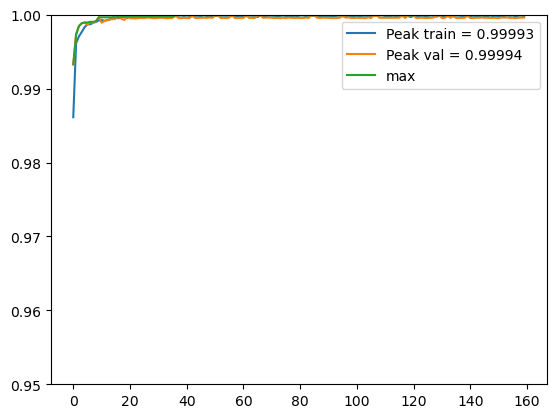

In [15]:
metric = ""
df = pd.read_csv(path_results)
val_auc_max = max(df["val_auc" + metric])
auc_max = max(df["auc" + metric])
largest = [max(df["val_auc" + metric][:i+1]) for i in range(len(df))]
plt.plot(df["auc" + metric],label='Peak train = {:.5f}'.format(auc_max))
plt.plot(df["val_auc" + metric], label='Peak val = {:.5f}'.format(val_auc_max))
plt.plot(largest, label='max')
plt.legend()
plt.ylim(0.95,1)
plt.show()


# print(f"Max train AUC: {auc_max:.5f}, Max val AUC: {val_auc_max:.5f}")

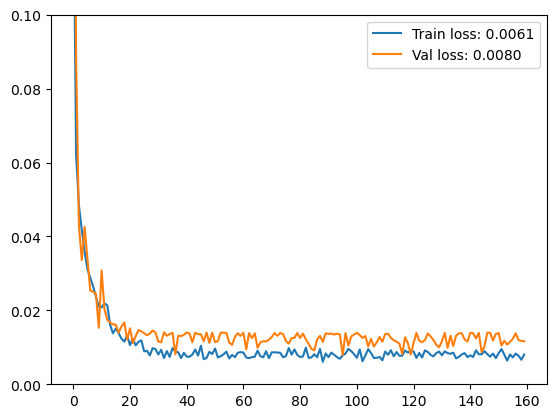

In [16]:
val_loss = min(df["val_loss"])
train_loss = min(df["loss"])
plt.plot(df["loss"],label=f'Train loss: {train_loss:.4f}')
plt.plot(df["val_loss"], label=f'Val loss: {val_loss:.4f}')
plt.ylim(top=0.1, bottom=0)
plt.legend()
plt.show()

In [17]:
pre_xval, _ = preprocess_val(xval, yval)

model.load_weights(f'{save_dir}/endrun.h5')
endrun_preds = model.predict(pre_xval)
model.load_weights(f'{save_dir}/chkpt.h5')
best_preds = model.predict(pre_xval)

2025-07-11 12:29:20.754433: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903


125/125 [==============================] - 1s 8ms/step


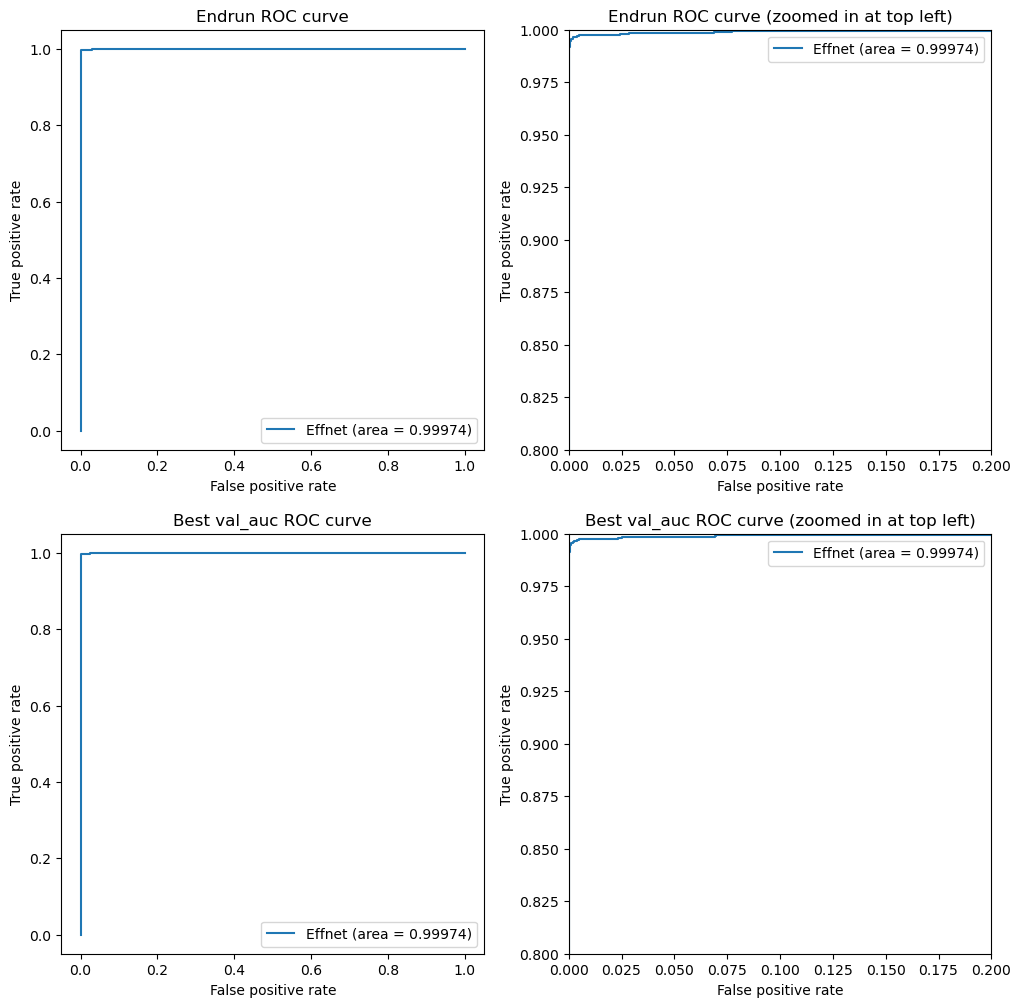

In [18]:
fpr, tpr, thresholds = roc_curve(yval, endrun_preds)
auc_roc = roc_auc_score(yval, endrun_preds)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0,0].plot(fpr, tpr, label='Effnet (area = {:.5f})'.format(auc_roc))
axs[0,0].set_xlabel('False positive rate')
axs[0,0].set_ylabel('True positive rate')
axs[0,0].set_title('Endrun ROC curve')
axs[0,0].legend(loc='best')

axs[0,1].set_xlim(0, 0.2)
axs[0,1].set_ylim(0.8, 1)
axs[0,1].plot(fpr, tpr, label='Effnet (area = {:.5f})'.format(auc_roc))
axs[0,1].set_xlabel('False positive rate')
axs[0,1].set_ylabel('True positive rate')
axs[0,1].set_title('Endrun ROC curve (zoomed in at top left)')
axs[0,1].legend(loc='best')

fpr, tpr, thresholds = roc_curve(yval, best_preds)
auc_roc2 = roc_auc_score(yval, best_preds)

axs[1,0].plot(fpr, tpr, label='Effnet (area = {:.5f})'.format(auc_roc2))
axs[1,0].set_xlabel('False positive rate')
axs[1,0].set_ylabel('True positive rate')
axs[1,0].set_title('Best val_auc ROC curve')
axs[1,0].legend(loc='best')

axs[1,1].set_xlim(0, 0.2)
axs[1,1].set_ylim(0.8, 1)
axs[1,1].plot(fpr, tpr, label='Effnet (area = {:.5f})'.format(auc_roc2))
axs[1,1].set_xlabel('False positive rate')
axs[1,1].set_ylabel('True positive rate')
axs[1,1].set_title('Best val_auc ROC curve (zoomed in at top left)')
axs[1,1].legend(loc='best')

plt.show()

In [22]:
attn_maps = attn_model.predict(pre_xval)

125/125 [==============================] - 2s 5ms/step


In [23]:
attn_maps.shape

(4000, 7, 7, 96)

In [24]:
avg_maps = np.mean(attn_maps, axis=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

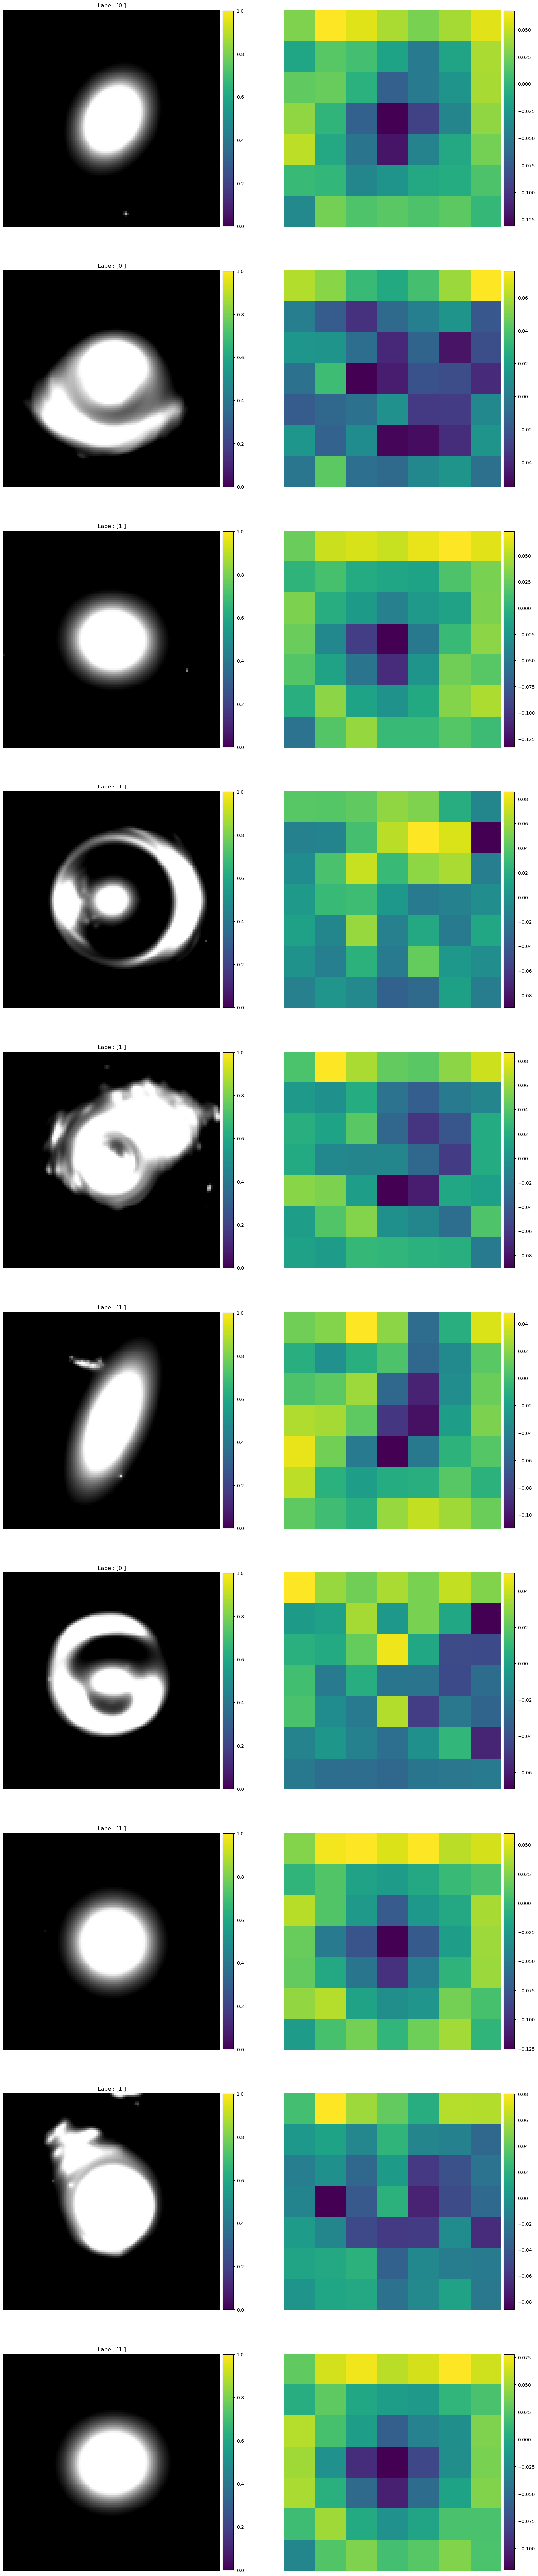

In [29]:
fig, axs = plt.subplots(10, 2, figsize=(20, 100))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.axis('off')
    row = i // 2
    col = i % 2
    if col == 0:
        im = ax.imshow(pre_xval[row])
        ax.set_title(f'Label: {yval[i]}')
    else:
        im = ax.imshow(avg_maps[row])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.01)
plt.show()